In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import pickle
from casbah import cgm as cas_cgm

import matplotlib.pyplot as plt

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy.io import fits

from scipy.integrate import quad
from scipy.interpolate import interp1d

import cgmsquared.clustering as cgm2_cluster

from scipy.optimize import minimize


from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.table import Table, vstack

from linetools import utils as ltu

from pyigm.clustering.xcorr_utils import random_gal

from casbah import utils as casu
from casbah import load_casbah as loadc
from casbah import cas_specdb
from casbah import cgm as cas_cgm
from casbah import clustering as cas_cluster
from casbah.plotting import set_fontsize

from cgmsquared import clustering as cgm2_cluster
from cgmsquared import load_cgmsquared
import cgmsquared.clustering2 as c2
from IPython.display import display, Math

from astropy.stats import binom_conf_interval
import glob

import casbah.plotting as cplt

import scipy.special


import emcee
import corner
# globals
# clight = 2.9979246e5
clight = const.c.to(u.km / u.s).value
plt.rcParams['font.size'] = 20
xmax = 3e0

import matplotlib
# plt.rcParams['mathtext.fontset']='stix'
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

np.random.seed(42)

# Check whether beta varies as a funciton of mass

1) 3 mass bins and fit for beta in each
2) fix r0 to previously fit value

In [2]:
def phit_1halo(theta, z, rho_com, mass, Hz, dv, vmax=500.):

    # fix m0
    m0 = 10**9.5

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    r0, r0_2, gamma, gamma_2, beta, beta_2, dndz_index, dndz_coeff = theta
    # use the analytic solution to chi_perp
    r0_mass = r0 * (mass / m0)**(beta)
    chi_i = c2.chi_perp_analytic(r0_mass, gamma, rho_com, z, Hz, dv)
    

    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z,
                                danforth=False,
                                gamma=dndz_index,
                                coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3

    rate_of_incidence = (1 + chi_i) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit

def phit_2halo(theta, z, rho_com, mass, Hz, dv, vmax=500., gamma_2halo_fixed=1.7):

    # fix m0
    m0 = 10**9.5

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    r0, r0_2, gamma, gamma_2, beta, beta_2, dndz_index, dndz_coeff = theta
    # use the analytic solution to chi_perp
    r0_mass = r0 * (mass / m0)**(beta)
    chi_i = c2.chi_perp_analytic(r0_mass, gamma, rho_com, z, Hz, dv)
    
    # there should be the two halo term power law with "fixed" parameters from Tejos+2014
    r0_mass_2 = r0_2 * (mass / m0)**(beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)


    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z,
                                danforth=False,
                                gamma=dndz_index,
                                coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3 

    rate_of_incidence = (1 + chi_i_2halo) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit

def phit_2halo_only(theta, z, rho_com, mass, Hz, dv, vmax=500., gamma_2halo_fixed=1.7):

    # fix m0
    m0 = 10**9.5

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    r0_2, gamma_2, beta_2, dndz_index, dndz_coeff = theta
    
    # two halo term power law
    r0_mass_2 = r0_2 * (mass / m0)**(beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)


    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z,
                                danforth=False,
                                gamma=dndz_index,
                                coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3 

    rate_of_incidence = (1 + chi_i_2halo) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit

def phit_2_power_law(theta, z, rho_com, mass, Hz, dv, vmax=500., gamma_2halo_fixed=1.7):

    # fix m0
    m0 = 10**9.5

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    r0, r0_2, gamma, gamma_2, beta, beta_2, dndz_index, dndz_coeff = theta
    # use the analytic solution to chi_perp
    r0_mass = r0 * (mass / m0)**(beta)
    chi_i = c2.chi_perp_analytic(r0_mass, gamma, rho_com, z, Hz, dv)
    
    # there should be the two halo term power law with "fixed" parameters from Tejos+2014
    r0_mass_2 = r0_2 * (mass / m0)**(beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)

    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z,
                                danforth=False,
                                gamma=dndz_index,
                                coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3
    
    rate_of_incidence = (1 + (chi_i + chi_i_2halo)) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit


def phit_2_power_law_3betas(theta, z, rho_com, mass, massidx, Hz, dv, vmax=500):
    # theta, z, rho_com, mass, massidx, Hz, dv, vmax=vmax
    # fix m0
    m0 = np.array([10**9, 10**9.5, 10**10])
    m0 = 10**10.5
    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    r0, r0_2, gamma, gamma_2, beta, beta2, dndz_index, dndz_coeff = theta
    
    
    
    # use the analytic solution to chi_perp
    r0_mass = r0 * (mass / m0)**(beta[massidx])
    chi_i = c2.chi_perp_analytic(r0_mass, gamma, rho_com, z, Hz, dv)
    
    # there should be the two halo term power law with "fixed" parameters from Tejos+2014
    m0_2h = 10**9.5
    r0_mass_2 = r0_2 * (mass / m0_2h)**(beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)

    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z,
                                danforth=False,
                                gamma=dndz_index,
                                coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3
    
    rate_of_incidence = (1 + (chi_i + chi_i_2halo)) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit


def log_likelihood_2_power_law(theta, z, rho_com, mass, massidx, hits, misses, Hz, dv, vmax=500., gamma_2halo=None):

    prob_hit = phit_2_power_law_3betas(theta, z, rho_com, mass, massidx, Hz, dv, vmax=500.)
    
    # artifically inflating the variance.
    prob_hit = np.clip(prob_hit, 0.01, 0.99)
    
    prob_miss = 1 - prob_hit


    log_prob_hits = np.log(prob_hit[hits])
    log_prob_miss = np.log(prob_miss[misses])
    

    sum_log_prob_miss = np.sum(log_prob_miss)
    sum_log_prob_hits = np.sum(log_prob_hits)

    llikelihood = sum_log_prob_hits + sum_log_prob_miss
    return llikelihood

nll = lambda *args: -log_likelihood_2_power_law(*args)

def log_prior(theta):
    r0, r0_2, gamma, gamma_2, beta0, beta1, beta2, beta_2, dndz_index, dndz_coeff = theta
    
    beta = np.array([beta0, beta1, beta2])

    # flat prior on r0, gaussian prior on gamma around 1.6
    if (r0 < 0) or (r0 > 5) or (r0_2 < 0) or (r0_2 > 10):
        return -np.inf
    if (gamma < 2) or (gamma > 10) or (gamma_2 < 0) or (gamma_2 > 10):
        return -np.inf
    if  (beta.any() < -1) or (beta.any() > 5) or (beta_2 < -1):
        return -np.inf
    if (dndz_index < -3) or (dndz_index > 3) or (dndz_coeff < 0) or (dndz_coeff > 40):
        return -np.inf
    
    sig = 1.0
    ln_prior = -0.5*((gamma - 6)**2/(sig)**2)
    ln_prior = -0.5*((gamma_2 - 1.7)**2/(0.1)**2) # tejos 2014
    ln_prior += -0.5*((r0 - 1)**2/(sig)**2) 
    ln_prior += -0.5*((r0_2 - 3.8)**2/(0.3)**2) # tejos 2014
    # ln_prior += -0.5*((beta - 0.5)**2/(sig)**2)
    ln_prior += np.sum(-0.5*((beta - 0.5)**2/(sig)**2))
    ln_prior += -0.5*((beta_2 - 0.5)**2/(sig)**2)
    ln_prior += -0.5*((dndz_index - 0.97)**2/(0.87)**2) # kim+
    ln_prior += -0.5*((np.log(dndz_coeff) - np.log(10)*1.25)**2/(np.log(10)*0.11)**2) - np.log(dndz_coeff) # kim+
    
    return ln_prior

def log_probability(theta, *args):
    lp = log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp - nll(theta, *args)

In [3]:
surveyfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
old_surveyfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos_paper1.json"

ion = 'HI'
cgm = load_cgmsquared.load_cgm_survey(build_sys=False, survey_file=surveyfile)
cgm.add_ion_to_data(ion)

read_sets: Using set file -- 
  /Users/mwilde/python/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [4]:
z_cgm, rho_com_cgm, mass_cgm, hits_cgm, misses_cgm, Hz_cgm, dv_cgm, cgm_data_doanly_cgm, do_anly_cgm = c2.collect_input_data(cgm)

Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 292


In [5]:
survey_files = glob.glob("/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits")
cas_tab_list = []
for cas_tab_file in survey_files:
    tab = Table.read(cas_tab_file)
    # add in useful naming conventions
    tab['rho_rvir'] = tab['rho_impact']/tab['rvir']
    tab['z'] = tab['z_1']
    tab['sig_logN_HI'] = tab['sig_logN']
    cas_tab_list.append(tab)

cgm_data_cas = vstack(cas_tab_list)

In [7]:
z_cas, rho_com_cas, mass_cas, hits_cas, misses_cas, Hz_cas, dv_cas, cgm_data_doanly_cas, do_anly_cas = c2.collect_input_data(cgm_data_cas)

Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1427
misses 5591


In [8]:
z = np.hstack([z_cgm, z_cas])
rho_com = np.hstack([rho_com_cgm, rho_com_cas])
mass = np.hstack([mass_cgm, mass_cas])
hits = np.hstack([hits_cgm, hits_cas])
misses = np.hstack([misses_cgm, misses_cas])
Hz = np.hstack([Hz_cgm, Hz_cas])
dv = 500. #km/s

In [9]:
z, rho_com, mass, hits, misses, Hz, dv, cgm_data_doanly, do_anly = c2.combine_cgm2_casbah_cluster_data(cgm, cgm_data_cas)

Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1294
misses 4775
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 292


In [18]:

massidx = np.digitize(mass, [0, 10**10.5])
massidx -= 1

In [11]:
massidx.shape

(6629,)

In [16]:
mass.shape

(6629,)

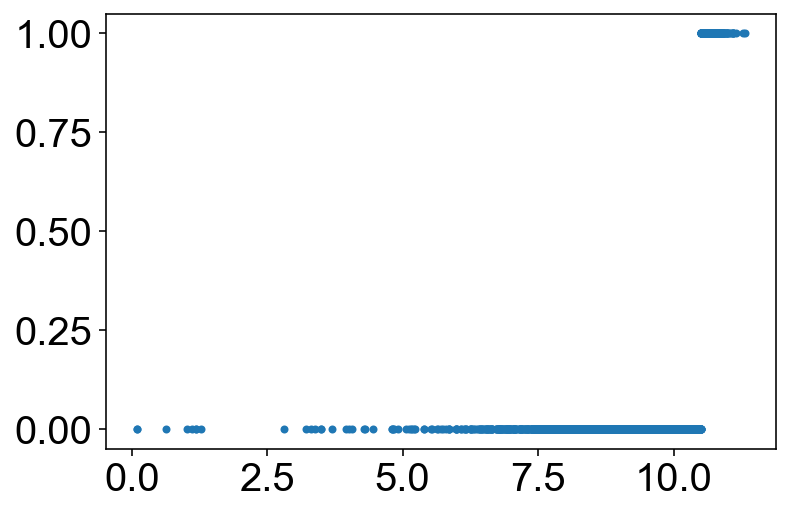

In [20]:
betavec = np.array([0, 1])
plt.plot(np.log10(mass), betavec[massidx], ls='none', marker='.')

In [21]:
galbeta = betavec[massidx]

In [22]:
galbeta

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
# create negative loglikelihood func in order to minimize
nll = lambda *args: -log_likelihood_2_power_law(*args)

r_0_initial = 1 # clustering scale
r_0_2 = 4
beta_2_initial = 0.05
gamma_initial = 6 # clutering powerlaw index
gamma_2_initial = 1.7
b_initial = 1. # additive constant to take care of normalization
dndz_index = 1.2 # dN/dz powerlaw index
dndz_coeff = 17

galbeta0 = 1/8
galbeta1 = 1/8


initial = np.array([r_0_initial, r_0_2, gamma_initial, gamma_2_initial, galbeta0, galbeta1, beta_2_initial, dndz_index, dndz_coeff])

soln = minimize(nll, initial, args=(z, rho_com, mass, massidx, hits, misses, Hz, dv), 
                bounds=((0.1, 10), (0.1, 10), (0, 6), (0, 6),(-2, 4),(-2, 4), (-2, 4), (-2, 3), (0, 30)))

ValueError: too many values to unpack (expected 5)

In [ ]:
r0_ml, r0_2_ml, gamma_ml, gamma_2_ml, beta_ml0, beta_ml1, beta_ml2, beta_ml_2, dndz_index, dndz_coeff = soln.x

print('\n')
print("Maximum likelihood estimates:")
print("=============================")
print("r0 = {0:.3f}".format(r0_ml))
print("r0_2h = {0:.3f}".format(r0_ml))
print("gamma = {0:.3f}".format(gamma_ml))
print("gamma_2h = {0:.3f}".format(gamma_2_ml))
print("beta = {0:.3f}".format(beta_ml0))
print("beta = {0:.3f}".format(beta_ml1))
print("beta = {0:.3f}".format(beta_ml2))
print("beta_2h = {0:.3f}".format(beta_ml_2))
print('dndz_index = {0:.3f}'.format(dndz_index))
print('dndz_index = {0:.3f}'.format(dndz_coeff))
print("=============================")



Maximum likelihood estimates:
r0 = 1.014
r0_2h = 1.014
gamma = 3.166
gamma_2h = 1.422
beta = 3.998
beta = 0.250
beta = 0.058
beta_2h = -0.010
dndz_index = 1.233
dndz_index = 28.449


In [ ]:
if os.path.exists("3betas.pkl"):
    
    infile = open("3betas.pkl",'rb')
    sampler = pickle.load(infile)
    infile.close()
else:

    from multiprocessing import Pool
    from multiprocessing import cpu_count

    ncpu = cpu_count()
    print("{0} CPUs".format(ncpu))

    with Pool() as pool:

        # pos = soln.x + 1e-4 * np.random.randn(12, soln.x.shape[0])
        pos = initial + 1e-4 * np.random.randn(2*initial.shape[0], initial.shape[0])
        nwalkers, ndim = pos.shape

        #soft_prob = lambda *args : 0.3*log_probability(*args)
        #sampler = emcee.EnsembleSampler(nwalkers, ndim, soft_prob, pool=pool,
        #                                args=(z, rho_com, mass, hits, misses, Hz, dv))

        #sampler.run_mcmc(pos, 10000, progress=True);
        #pos = sampler.chain[:,-1]
        #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool,
        #                                args=(z, rho_com, mass, hits, misses, Hz, dv))

        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                        args=(z, rho_com, mass, massidx, hits, misses, Hz, dv))


        sampler.run_mcmc(pos, 4000, progress=True);

    # save the sampler    
    with open("3betas.pkl", "wb") as f:
        pickle.dump(sampler, f)

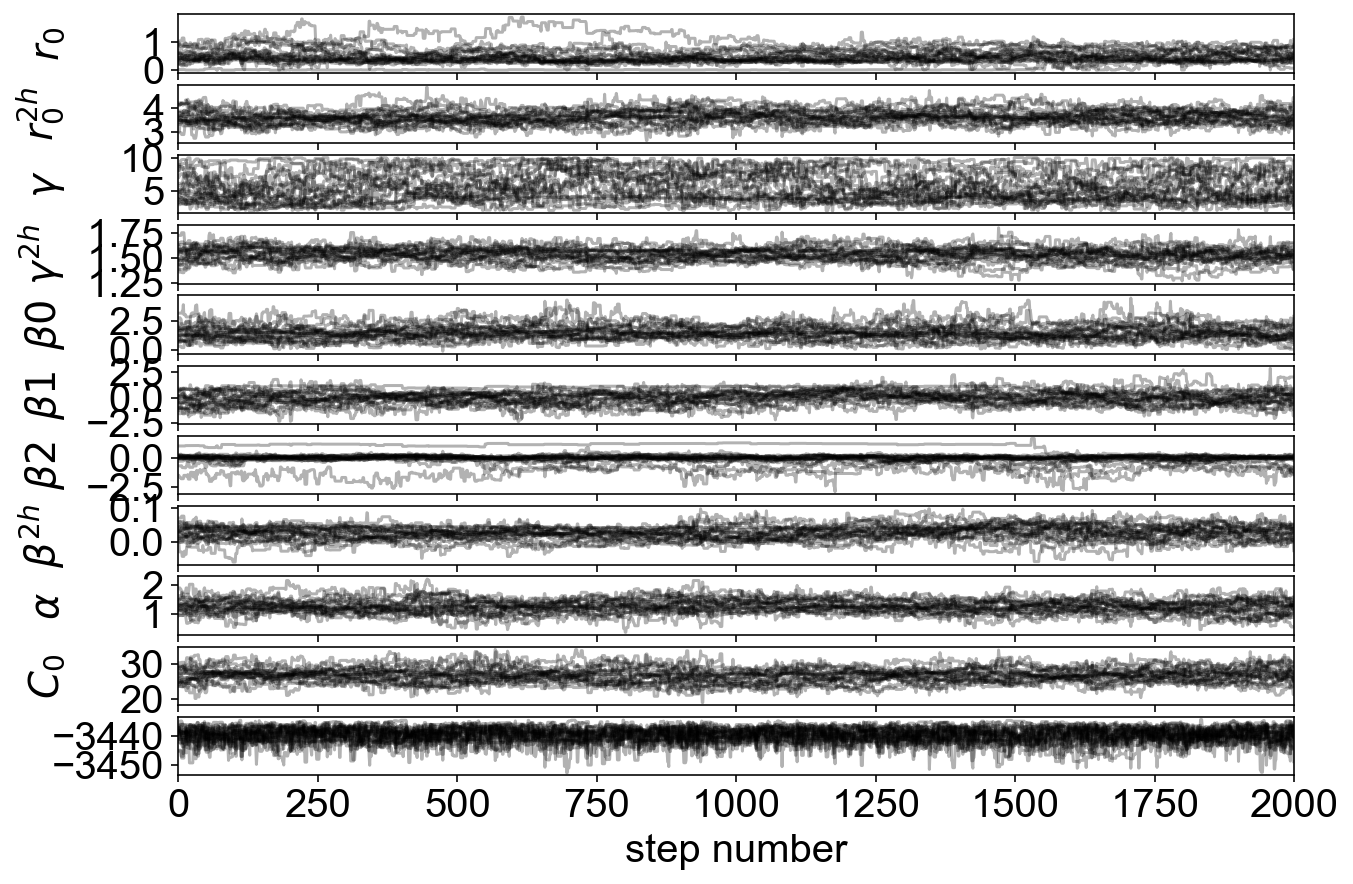

In [ ]:
samples = sampler.get_chain(discard=2000)
flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)
ndim = samples.shape[2]

# plot
fig, axes = plt.subplots(nrows=ndim+1, figsize=(10, 7), sharex=True)
labels = [r"$r_0$", r"$r_0^{2h}$", r"$\gamma$", r"$\gamma^{2h}$", r"$\beta0$",r"$\beta1$", r"$\beta2$", r"$\beta^{2h}$", r'$\alpha$', r'$C_0$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

axes[-1].plot(sampler.lnprobability.T[2000:], "k", alpha=0.3);

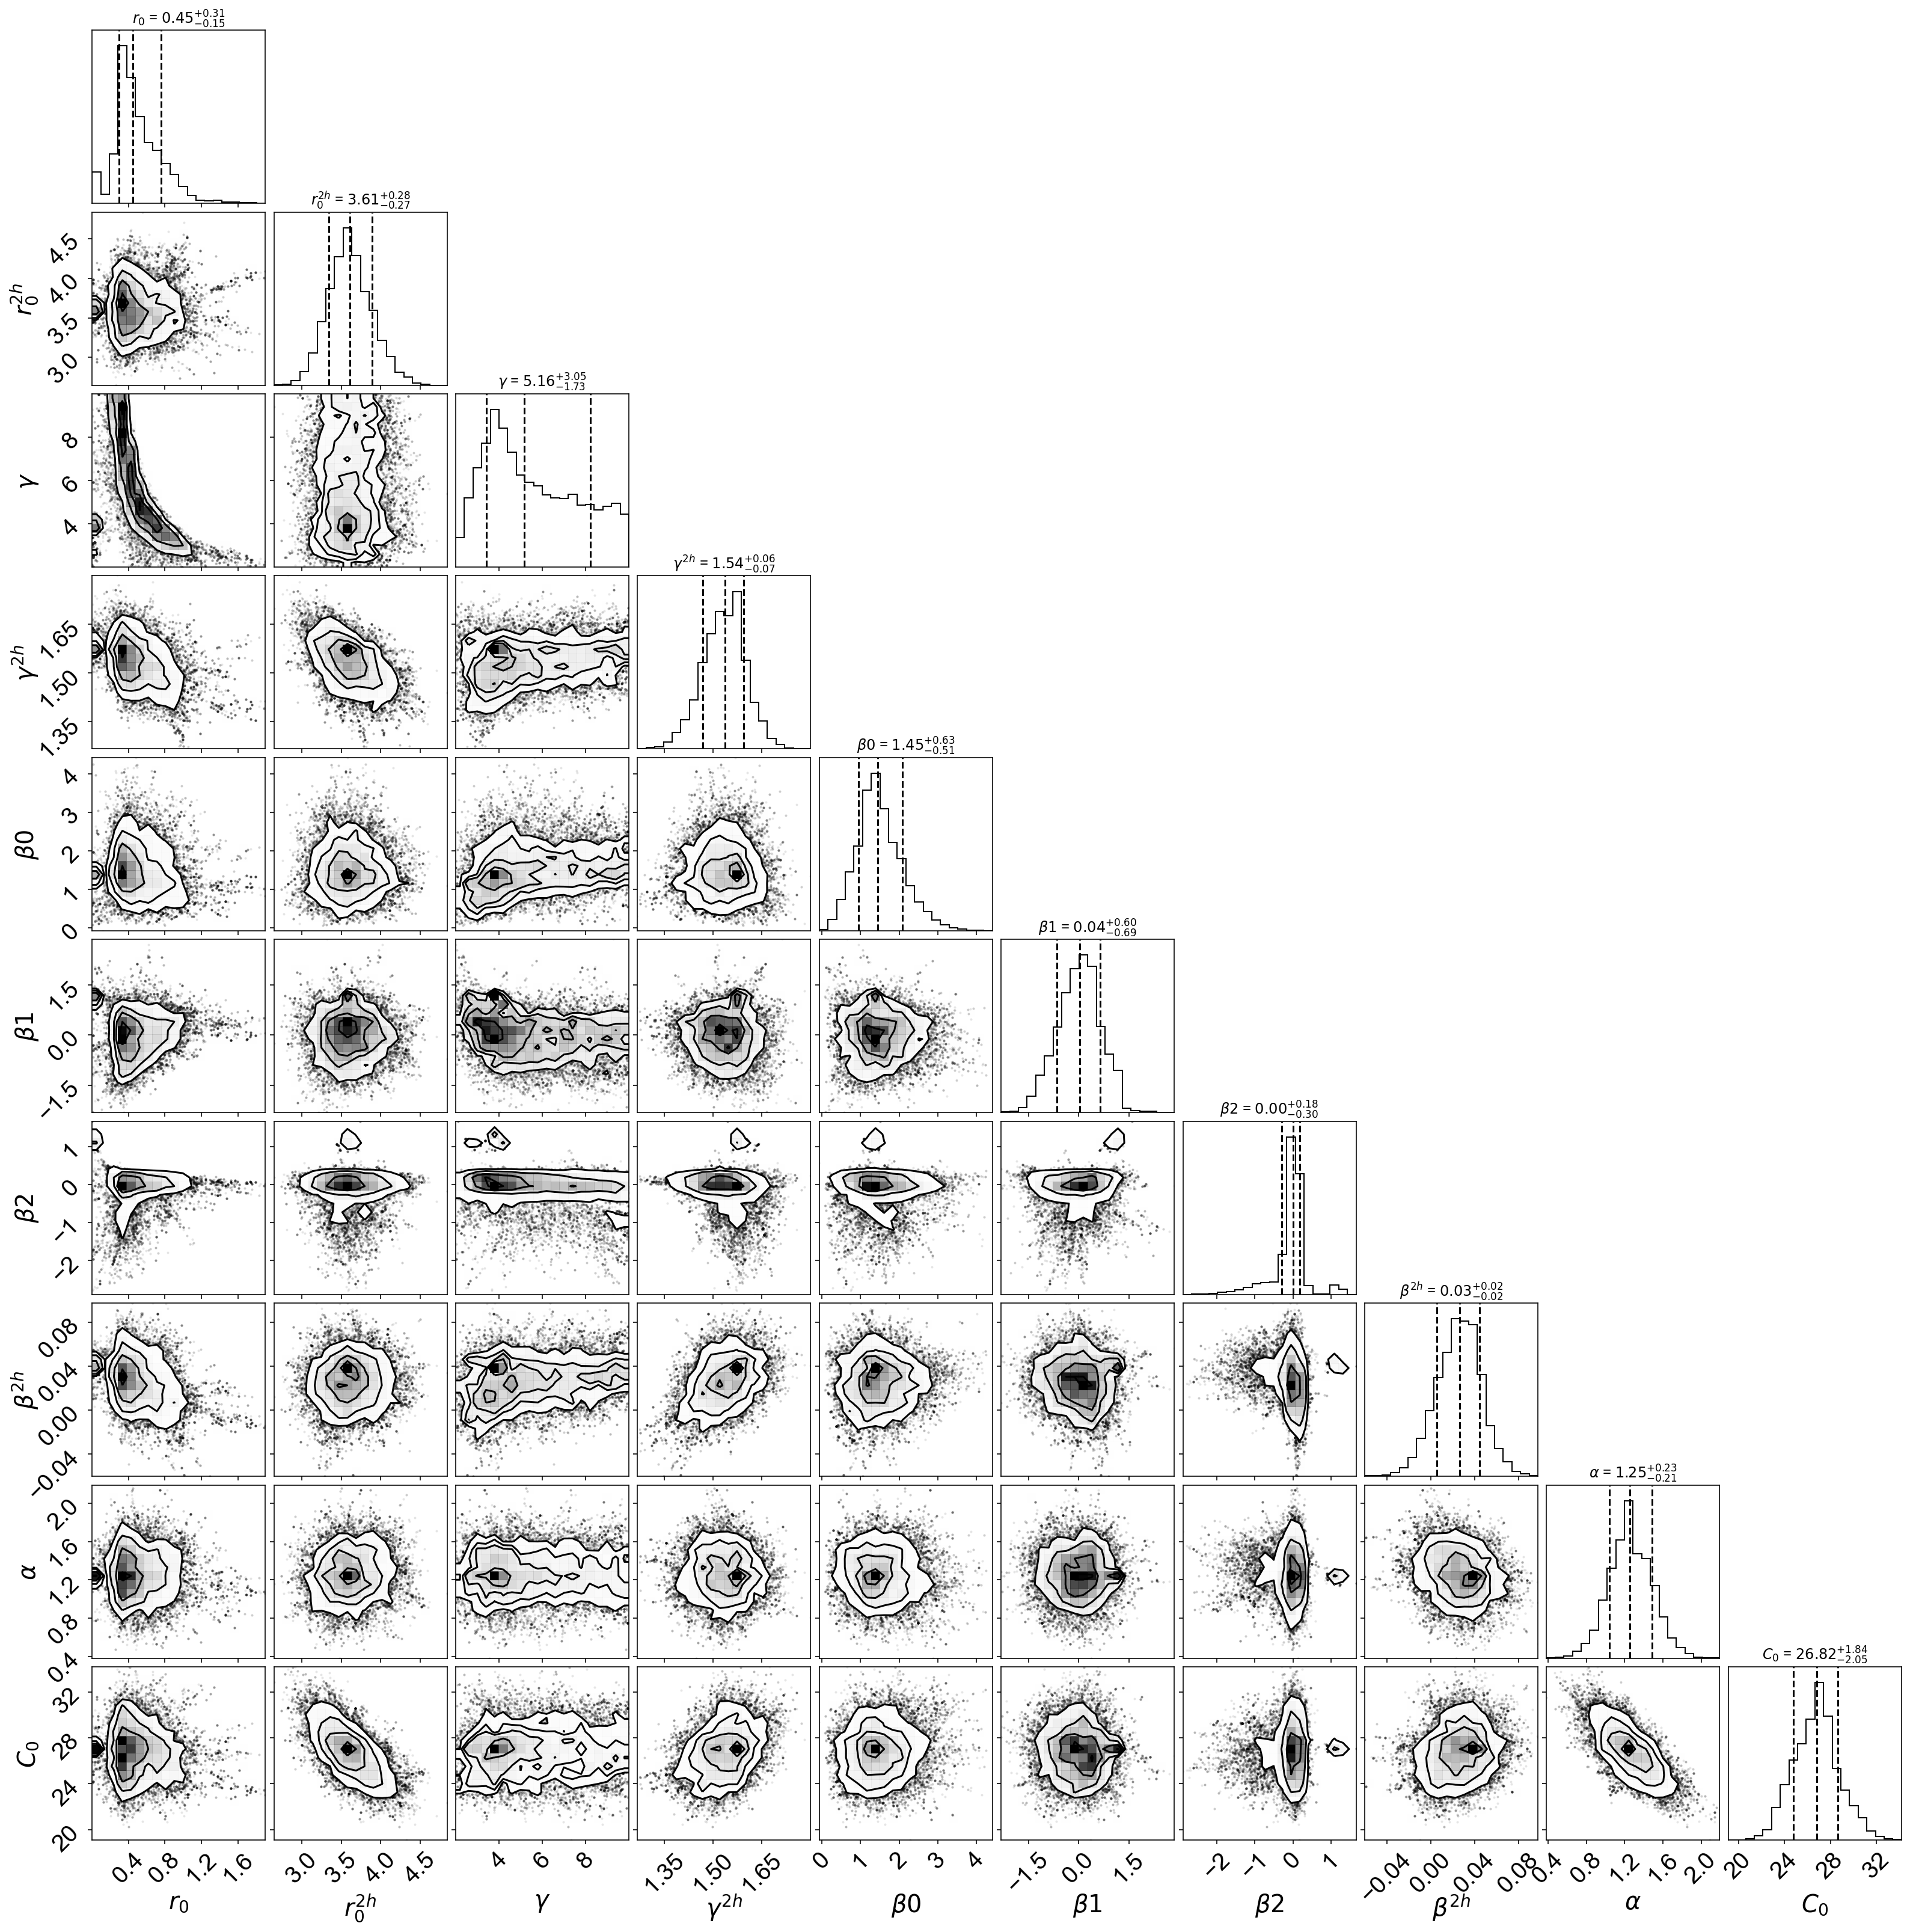

In [ ]:
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
);